In [1]:
import pandas as pd
import helper.entsoe_wrapper as entsoe_wrapper
import helper.capacity as capacity
import numpy as np
from entsoe import EntsoePandasClient
import matplotlib.pyplot as plt
country="AT"
start=pd.Timestamp('2022-01-01', tz='UTC')
end=pd.Timestamp('2023-01-01', tz='UTC')
client = EntsoePandasClient(api_key="96ebcf8b-a543-4309-b167-322d5e0d5684")

In [2]:
countries=["AT","DE","BE","NL","FR","ES","IE","PL","SE","IT"]

In [3]:
used_capa=[]
for country in countries:
    print(country)
    used_capa.append(capacity.get_usage_percentage_variable_generation(country,start,end))

AT
DE
BE
NL
FR
ES
IE


c:\Daten\Foschung\RiskAware\IntensityLib\helper\capacity.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  generation=generation.fillna(method='ffill')


PL
SE
IT


In [6]:
countries_show=["NL","IE","FR","ES"]

In [7]:
import plotly.graph_objects as go

fig = go.Figure()

for i,country in enumerate(countries_show):
    if country in countries:
        i=countries.index(country)
    fig.add_trace(go.Scatter(x=used_capa[i].index, y=used_capa[i], mode='lines', name=countries[i]))

fig.update_layout(title='Usage Capacity for Different Countries',
                  xaxis_title='Time',
                  yaxis_title='Usage Capacity',
                  legend_title='Countries',
                  width=1200,
                  height=600)

fig.show()

In [24]:
generation=entsoe_wrapper.get_generation_data_1h(country=country, start=start, end=end)
drop_col=[col for col in generation.columns if 'Consumption' in col]
generation.drop(columns=drop_col, inplace=True)
generation.columns=generation.columns.str.replace('_Actual Aggregated','')

In [25]:
# Query unavailability of generation units
country_code = country
outages = entsoe_wrapper.get_outages(country=country_code, start=start, end=end)

C:\Users\jos82vs.UNI-WUERZBURG\AppData\Roaming\Python\Python311\site-packages\entsoe\decorators.py:79: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

C:\Users\jos82vs.UNI-WUERZBURG\AppData\Roaming\Python\Python311\site-packages\entsoe\decorators.py:79: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [26]:
missing_capa=entsoe_wrapper.get_missing_capacity(country=country_code, start=start, end=end)
installed_capa=entsoe_wrapper.get_installed_capacity(country=country, start=start, end=end)

In [27]:
#extend missing_capa with the columns of installed_capa that are not in missing_capa and put 0 in the missing values
installed_capa=installed_capa.reindex(columns=generation.columns, fill_value=0) 
missing_capa = missing_capa.reindex(columns=installed_capa.columns, fill_value=0)
remaining_capa = -missing_capa.subtract(installed_capa.iloc[0], axis=1)
usage_percentage= (remaining_capa-generation)/remaining_capa
usage_percentage.replace(np.nan, 0, inplace=True)

In [28]:
#Calculate the usage percentage of all variable generation units
units=['Biomass','Fossil Brown coal/Lignite','Fossil Coal-derived gas','Fossil Gas','Fossil Hard coal','Fossil Oil','Fossil Oil shale','Fossil Peat','Hydro Pumped Storage','Hydro Water Reservoir','Nuclear','Other','Waste']
units_intersect=remaining_capa.columns.intersection(units)
variable_gen_capa=remaining_capa[units_intersect].sum(axis=1)
variable_gen=generation[units_intersect].sum(axis=1)
variable_gen_usage_percentage=1-(variable_gen_capa-variable_gen)/variable_gen_capa
variable_gen_usage_percentage.replace(0, variable_gen_usage_percentage.mean(), inplace=True)

In [29]:
import plotly.express as px

fig = px.line(variable_gen_usage_percentage, title='Variable Generation Usage Percentage Over Time')
fig.show()

In [30]:
installed_capa.reset_index(drop=True, inplace=True)

# Create a DataFrame to store the percentage of missing capacity
missing_capacity_percentage = pd.DataFrame(columns=outages.plant_type.unique(), index=pd.date_range(start, end, freq='h'))

# Calculate the percentage of missing capacity for each plant type
for plant_type in missing_capa.columns:
    missing_capacity_percentage[plant_type] = missing_capa[plant_type].astype(float) / installed_capa[plant_type][0]

# Calculate the total missing capacity and the total installed capacity
total_missing_capacity = missing_capa.sum(axis=1)
total_installed_capacity = installed_capa.sum(axis=1)[0]

# Calculate the percentage of total missing capacity
total_missing_capacity_percentage = total_missing_capacity / total_installed_capacity

<Axes: >

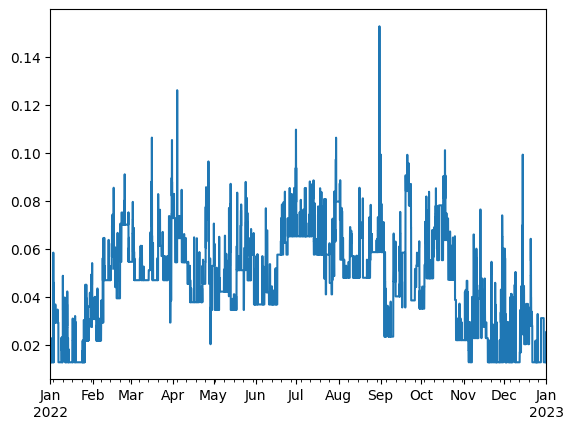

In [31]:
total_missing_capacity_percentage.plot()